In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import os

from fastai.vision.data import ImageDataLoaders
from fastai.vision import models
from fastai.vision.all import cnn_learner
from fastai.metrics import RocAuc, accuracy, error_rate
from fastai.interpret import ClassificationInterpretation
from pathlib import Path

from colorama import Fore, Back, Style

y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
res = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')

PATH = '/kaggle/input/siim-covid19-detection/'
submission = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv', index_col=None)
image_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_image_level.csv', index_col=None)
study_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_study_level.csv', index_col=None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
print(f"{y_}Train image level csv shape : {image_df.shape}{res}\n{g_}Train study level csv shape : {study_df.shape}{res}")

Train image level csv shape : (6334, 4)
Train study level csv shape : (6054, 5)


In [2]:
all_files = []
for dirname, _, filenames in os.walk('/kaggle/input/image-resize-siim-covid-19-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/image-resize-siim-covid-19-detection/test.tar.gz
/kaggle/input/image-resize-siim-covid-19-detection/__results__.html
/kaggle/input/image-resize-siim-covid-19-detection/train.tar.gz
/kaggle/input/image-resize-siim-covid-19-detection/__resultx__.html
/kaggle/input/image-resize-siim-covid-19-detection/__notebook__.ipynb
/kaggle/input/image-resize-siim-covid-19-detection/__output__.json
/kaggle/input/image-resize-siim-covid-19-detection/custom.css


In [3]:
!mkdir train
!cd train
!tar xzf /kaggle/input/image-resize-siim-covid-19-detection/train.tar.gz

In [4]:
!pwd

/kaggle/working


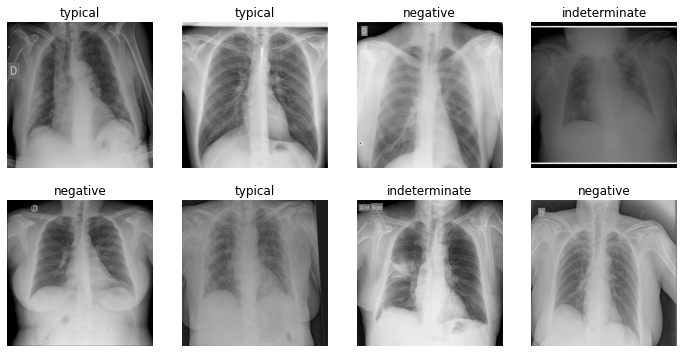

In [5]:
trn_path = Path('/kaggle/working/')
dl = ImageDataLoaders.from_folder(trn_path, train='train', bs=8, valid_pct=.1, seed=42)
dl.train.show_batch()

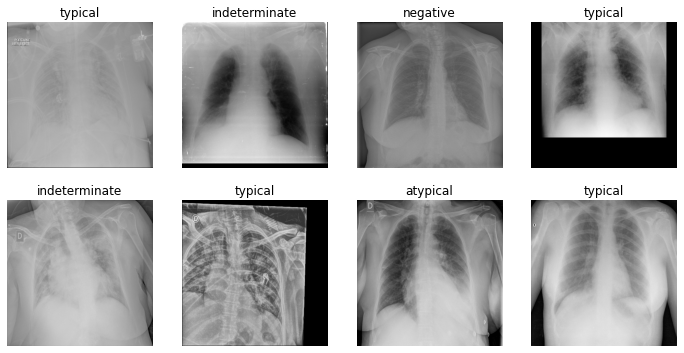

In [6]:
dl.valid.show_batch()

In [7]:
learn = cnn_learner(dl, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.319060,1.136469,0.418641,02:43
1,1.135440,1.033066,0.402844,02:39


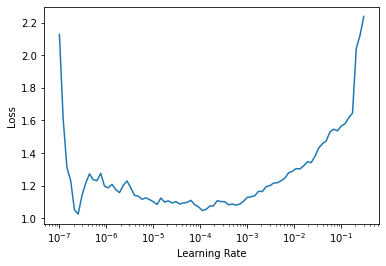

In [9]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find()

In [10]:
lr_min

1.0964782268274575e-05

In [11]:
learn.fit_one_cycle(20, lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,1.054606,1.025411,0.399684,03:33
1,0.983068,1.018300,0.407583,03:32
2,0.969153,1.040902,0.399684,03:33
3,0.949491,1.022770,0.390205,03:34
4,0.954719,1.028832,0.372828,03:33
5,0.810472,1.094550,0.406003,03:34
6,0.639550,1.213512,0.404423,03:34
7,0.515004,1.246267,0.431280,03:33
8,0.385028,1.327588,0.417062,03:34
9,0.307365,1.367909,0.428120,03:33


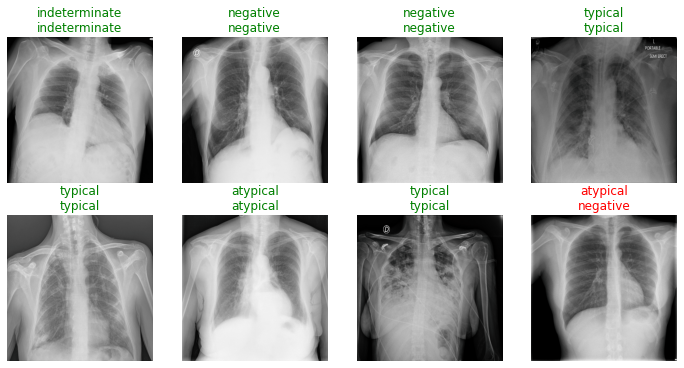

In [12]:
learn.show_results()

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

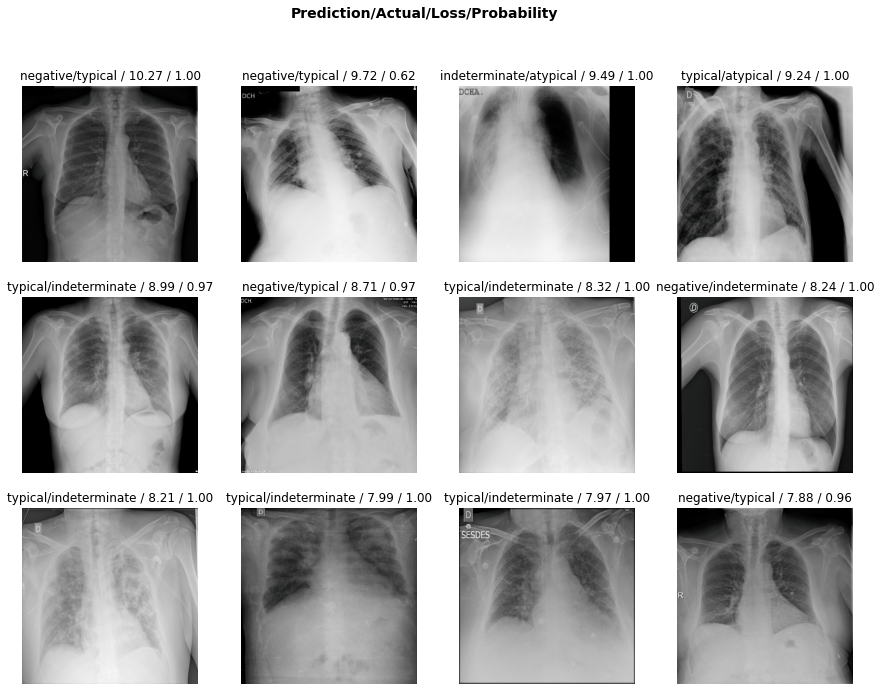

In [14]:
interp.plot_top_losses(12, figsize=(15,11))

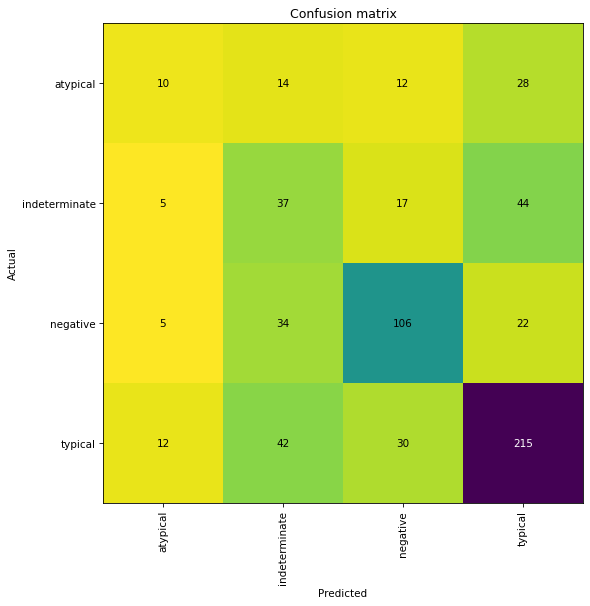

In [15]:
interp.plot_confusion_matrix(figsize=(8,8), cmap='viridis_r', dpi=75)

In [16]:
interp.most_confused()

[('indeterminate', 'typical', 44),
 ('typical', 'indeterminate', 42),
 ('negative', 'indeterminate', 34),
 ('typical', 'negative', 30),
 ('atypical', 'typical', 28),
 ('negative', 'typical', 22),
 ('indeterminate', 'negative', 17),
 ('atypical', 'indeterminate', 14),
 ('atypical', 'negative', 12),
 ('typical', 'atypical', 12),
 ('indeterminate', 'atypical', 5),
 ('negative', 'atypical', 5)]

In [17]:
interp.print_classification_report()

               precision    recall  f1-score   support

     atypical       0.31      0.16      0.21        64
indeterminate       0.29      0.36      0.32       103
     negative       0.64      0.63      0.64       167
      typical       0.70      0.72      0.71       299

     accuracy                           0.58       633
    macro avg       0.49      0.47      0.47       633
 weighted avg       0.58      0.58      0.58       633

